<a href="https://colab.research.google.com/github/YuXuan20040221/GDpj/blob/cloud/RoadDamage_Cloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 道路安全

注意事項:

* 需要用到GPU到 執行階段 > 變更執行階段類型去設定
* 打 "*" 號的地方是剛開始(打開colab)時需要執行的
* 要換資料集到"資料集設定" (旁邊的目錄有寫)
* 設定修改之後要先跑一次讓他寫進檔案才有效
* 調整參數到"訓練"


# *掛載 Google Drive
讓 Colab 讀取放在雲端硬碟的資料集
(這邊不用動)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# *安裝相關套件

* 解yaml的
* 計算指標工具

In [2]:
!pip install pyyaml
!pip install torchmetrics
!pip install torchvision tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

先當作沒看到要轉成新的在下面

# 設定(yaml)

## 資料集設定:

自行修改資料集目錄路徑

In [3]:
# 定義train.yaml ->
yaml_content = """
path: /content/drive/MyDrive/datasets  # 整體資料集根目錄
train: Processed/TL2GF/images # 訓練用資料夾位置
val: Processed/TL2GF/images # 驗證用資料夾位置

nc: 3 # 類別個數
names: names: ["pothole", "Linear crack", "alligator crack"] # 類別名稱[洞、裂縫、鱷魚裂紋]

"""

# 寫入雲端 ->
with open("/content/drive/MyDrive/datasets/train.yaml", "w") as f:
    f.write(yaml_content)

# 訓練

# 整合資料
洞從yaml轉

linear crack 資料mask轉換成txt

In [11]:
import os
import shutil
import json
import cv2
import numpy as np
from tqdm import tqdm

edmcrack_root = "/content/drive/MyDrive/datasets/EdmCrack600"
alligator_root = "/content/drive/MyDrive/datasets/ALLIGATOR CRACK-1.v1i.coco/train"
pothole_root = "/content/drive/MyDrive/datasets/Processed/TL2GF"

output_root = "/content/drive/MyDrive/datasets/cloudDataset"
images_out = os.path.join(output_root, "images")
labels_out = os.path.join(output_root, "labels")

os.makedirs(images_out, exist_ok=True)
os.makedirs(labels_out, exist_ok=True)

cls_map = {
    "pothole": 0,
    "linear_crack": 1,
    "alligator_crack": 2,
}

def mask_to_yolo(box, img_w, img_h):
    x_center = (box[0] + box[2]) / 2.0 / img_w
    y_center = (box[1] + box[3]) / 2.0 / img_h
    w = (box[2] - box[0]) / img_w
    h = (box[3] - box[1]) / img_h
    return [x_center, y_center, w, h]

print("開始轉換 EdmCrack600 (linear crack) ...")
edm_images_dir = os.path.join(edmcrack_root, "images")
edm_ann_dir = os.path.join(edmcrack_root, "annotations")

for fname in tqdm(os.listdir(edm_images_dir)):
    if not fname.endswith((".png", ".jpg", ".jpeg")):
        continue
    img_path = os.path.join(edm_images_dir, fname)
    ann_path = os.path.join(edm_ann_dir, fname)

    shutil.copy(img_path, os.path.join(images_out, fname))

    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    mask = cv2.imread(ann_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    yolo_boxes = []
    for cnt in contours:
        x, y, bw, bh = cv2.boundingRect(cnt)
        if bw > 5 and bh > 5:
            box = [x, y, x + bw, y + bh]
            yolo_box = mask_to_yolo(box, w, h)
            yolo_boxes.append(yolo_box)

    txt_path = os.path.join(labels_out, os.path.splitext(fname)[0] + ".txt")
    with open(txt_path, "w") as f:
        for box in yolo_boxes:
            f.write(f"1 {' '.join(map(str, box))}\n")

print("EdmCrack600 轉換完成！")

print("開始轉換 Alligator Crack COCO 格式 ...")
coco_json_path = os.path.join(alligator_root, "_annotations.coco.json")

with open(coco_json_path) as f:
    coco = json.load(f)

images_info = {img["id"]: img for img in coco["images"]}
annotations = coco["annotations"]

ann_map = {}
for ann in annotations:
    img_id = ann["image_id"]
    bbox = ann["bbox"]
    if img_id not in ann_map:
        ann_map[img_id] = []
    ann_map[img_id].append(bbox)

for img_id, img_info in tqdm(images_info.items()):
    file_name = img_info["file_name"]
    img_path = os.path.join(alligator_root, file_name)

    shutil.copy(img_path, os.path.join(images_out, file_name))

    h, w = img_info["height"], img_info["width"]

    yolo_boxes = []
    for bbox in ann_map.get(img_id, []):
        x, y, bw, bh = bbox
        box = [x, y, x + bw, y + bh]
        yolo_box = mask_to_yolo(box, w, h)
        yolo_boxes.append(yolo_box)

    txt_path = os.path.join(labels_out, os.path.splitext(file_name)[0] + ".txt")
    with open(txt_path, "w") as f:
        for box in yolo_boxes:
            f.write(f"2 {' '.join(map(str, box))}\n")

print("Alligator Crack COCO 轉換完成！")

print("複製 pothole (坑洞) 資料 ...")
pothole_images_dir = os.path.join(pothole_root, "images")
pothole_labels_dir = os.path.join(pothole_root, "labels")

for fname in tqdm(os.listdir(pothole_images_dir)):
    if not fname.endswith((".png", ".jpg", ".jpeg")):
        continue
    shutil.copy(os.path.join(pothole_images_dir, fname), os.path.join(images_out, fname))
    txt_src = os.path.join(pothole_labels_dir, os.path.splitext(fname)[0] + ".txt")
    txt_dst = os.path.join(labels_out, os.path.splitext(fname)[0] + ".txt")
    if os.path.exists(txt_src):
        shutil.copy(txt_src, txt_dst)
    else:
        open(txt_dst, "w").close()

print("坑洞資料複製完成！")

yaml_path = os.path.join(output_root, "train.yaml")
yaml_content = f"""
path: {output_root}
train: images
val: images
nc: 3
names: ["pothole", "linear crack", "alligator crack"]
"""

with open(yaml_path, "w") as f:
    f.write(yaml_content.strip())

print(f"訓練 yaml 已生成: {yaml_path}")
print("資料整合完成")


開始轉換 EdmCrack600 (linear crack) ...


100%|██████████| 600/600 [12:48<00:00,  1.28s/it]


EdmCrack600 轉換完成！
開始轉換 Alligator Crack COCO 格式 ...


100%|██████████| 129/129 [02:49<00:00,  1.32s/it]


Alligator Crack COCO 轉換完成！
複製 pothole (坑洞) 資料 ...


100%|██████████| 186/186 [03:57<00:00,  1.28s/it]

坑洞資料複製完成！
訓練 yaml 已生成: /content/drive/MyDrive/datasets/cloudDataset/train.yaml
資料整合完成


分割資料集（建立 train/val）

In [12]:
import os
import random
import shutil

# 資料根目錄
root = "/content/drive/MyDrive/datasets/cloudDataset"
images_dir = os.path.join(root, "images")
labels_dir = os.path.join(root, "labels")

# 分割後輸出資料夾
train_img_dir = os.path.join(root, "train/images")
train_label_dir = os.path.join(root, "train/labels")
val_img_dir = os.path.join(root, "val/images")
val_label_dir = os.path.join(root, "val/labels")

# 建立資料夾
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

# 所有圖檔
all_images = [f for f in os.listdir(images_dir) if f.endswith((".png", ".jpg", ".jpeg"))]
random.shuffle(all_images)

# 分割比例
split_ratio = 0.8
split_index = int(len(all_images) * split_ratio)

train_files = all_images[:split_index]
val_files = all_images[split_index:]

def copy_split_data(file_list, img_src_dir, label_src_dir, img_dst_dir, label_dst_dir):
    for f in file_list:
        # 複製圖像
        shutil.copy(os.path.join(img_src_dir, f), os.path.join(img_dst_dir, f))

        # 複製標註
        label_name = os.path.splitext(f)[0] + ".txt"
        src_label_path = os.path.join(label_src_dir, label_name)
        dst_label_path = os.path.join(label_dst_dir, label_name)

        if os.path.exists(src_label_path):
            shutil.copy(src_label_path, dst_label_path)
        else:
            print(f"⚠️ 找不到標註檔案：{label_name}")

# 執行分割與複製
copy_split_data(train_files, images_dir, labels_dir, train_img_dir, train_label_dir)
copy_split_data(val_files, images_dir, labels_dir, val_img_dir, val_label_dir)

print("✅ 資料分割完成！")
print(f"訓練集圖片數量：{len(train_files)}")
print(f"驗證集圖片數量：{len(val_files)}")



✅ 資料分割完成！
訓練集圖片數量：732
驗證集圖片數量：183


train.yaml

In [13]:
import os

output_root = "/content/drive/MyDrive/datasets/cloudDataset"

yaml_path = os.path.join(output_root, "train.yaml")
yaml_content = f"""
path: {output_root}
train: train/images
val: val/images
nc: 3
names: ["pothole", "linear crack", "alligator crack"]
"""

with open(yaml_path, "w") as f:
    f.write(yaml_content.strip())

print(f"✅ train.yaml 已成功寫入：{yaml_path}")


✅ train.yaml 已成功寫入：/content/drive/MyDrive/datasets/cloudDataset/train.yaml


## 資料加載
將YOLO格式轉成faster R-CNN資料格式

In [14]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image
import torchvision.transforms as T
import os
import yaml

# ==========================
# Dataset 部分
# ==========================
class YoloToFasterRCNNDataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_paths = []
        self.label_paths = []
        self.transforms = transforms

        for fname in sorted(os.listdir(image_dir)):
            if fname.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(image_dir, fname)
                label_path = os.path.join(label_dir, os.path.splitext(fname)[0] + ".txt")

                # 檢查標註檔存在且非空
                if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                    # 再檢查標註檔裡有沒有至少一個box
                    with open(label_path) as f:
                        lines = [line.strip() for line in f.readlines() if line.strip()]
                    if len(lines) > 0:
                        self.image_paths.append(img_path)
                        self.label_paths.append(label_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = Image.open(img_path).convert("RGB")
        w, h = image.size

        boxes = []
        labels = []

        with open(label_path) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, cx, cy, bw, bh = map(float, parts)
                x1 = (cx - bw / 2) * w
                y1 = (cy - bh / 2) * h
                x2 = (cx + bw / 2) * w
                y2 = (cy + bh / 2) * h
                boxes.append([x1, y1, x2, y2])
                labels.append(int(cls) + 1)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels
        }

        if self.transforms:
            image = self.transforms(image)
        else:
            image = F.to_tensor(image)

        return image, target


In [15]:
import os

labels_path = "/content/drive/MyDrive/datasets/cloudDataset/labels"
empty_labels = []

for fname in os.listdir(labels_path):
    if fname.endswith(".txt"):
        fpath = os.path.join(labels_path, fname)
        if os.path.getsize(fpath) == 0:
            empty_labels.append(fname)

print(f"總共有 {len(empty_labels)} 個標註檔是空的！")
print(empty_labels[:10])  # 顯示前 10 個檔名

總共有 15 個標註檔是空的！
['K_13480_jpeg_jpg.rf.0f921c357b2402e51e4334f999534202.txt', 'r26_jpeg.rf.2ebef01a38b9ebdb0578fcf8eee50f12.txt', 'r18_jpeg.rf.391348e32a5a6ad8599448f1f8bda20c.txt', 'r17_jpeg.rf.476db8395f39c2ee797887ed2d2a4ab9.txt', 'r19_jpeg.rf.3c4850397e3aaa6f79ac9bc9b4720989.txt', 'r30_jpeg.rf.435f77ae2b03e436fa81ba667107015f.txt', 'r25_jpeg.rf.72d4f18229dde696097291027837323c.txt', 'r39_jpeg.rf.7b3b818cee1b39e528809247de6477e2.txt', 'K_13480_jpeg_jpg.rf.95e7719490e5ac6c22fd36373b3cff47.txt', 'r24_jpeg.rf.a878bc5c800e05acbe44153344c6fe73.txt']


## 訓練主程式

In [16]:
import os
import time
import torch
import pandas as pd
from PIL import Image
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as F
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# ===========================
# 1. Dataset 定義（過濾空標註）
# ===========================
class YoloToFasterRCNNDataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        all_images = sorted([
            fname for fname in os.listdir(image_dir)
            if fname.endswith(('.jpg', '.jpeg', '.png'))
        ])

        # 過濾出有非空標註的圖片檔名
        self.image_paths = []
        for fname in all_images:
            label_path = os.path.join(label_dir, os.path.splitext(fname)[0] + ".txt")
            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                self.image_paths.append(os.path.join(image_dir, fname))

        self.label_dir = label_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = os.path.join(
            self.label_dir,
            os.path.splitext(os.path.basename(img_path))[0] + ".txt"
        )

        image = Image.open(img_path).convert("RGB")
        w, h = image.size

        boxes = []
        labels = []

        with open(label_path) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, cx, cy, bw, bh = map(float, parts)
                x1 = (cx - bw / 2) * w
                y1 = (cy - bh / 2) * h
                x2 = (cx + bw / 2) * w
                y2 = (cy + bh / 2) * h
                boxes.append([x1, y1, x2, y2])
                labels.append(int(cls) + 1)  # +1 背景為 0

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels
        }

        if self.transforms:
            image = self.transforms(image)
        else:
            image = F.to_tensor(image)

        return image, target


# ===========================
# 2. 評估函式
# ===========================
def evaluate_model(model, dataloader, device='cuda'):
    model.eval()
    metric = MeanAveragePrecision()

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
            outputs = [{k: v.cpu() for k, v in o.items()} for o in outputs]
            targets = [{k: v.cpu() for k, v in t.items()} for t in targets]

            metric.update(outputs, targets)

    result = metric.compute()
    return 1 - result['map_50'].item(), result['map_50'].item(), result['map'].item()


# ===========================
# 3. 設定 Dataset 與 DataLoader
# ===========================
train_dataset = YoloToFasterRCNNDataset(
    image_dir="/content/drive/MyDrive/datasets/cloudDataset/train/images",
    label_dir="/content/drive/MyDrive/datasets/cloudDataset/train/labels"
)
val_dataset = YoloToFasterRCNNDataset(
    image_dir="/content/drive/MyDrive/datasets/cloudDataset/val/images",
    label_dir="/content/drive/MyDrive/datasets/cloudDataset/val/labels"
)

dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


# ===========================
# 4. 模型與訓練流程
# ===========================
model = fasterrcnn_resnet50_fpn(weights='DEFAULT')
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 3 + 1  # 3 種類別 + 背景
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to('cuda')

optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=1e-4, weight_decay=5e-4)

log = []
best_val_loss = float('inf')
save_dir = f"/content/drive/MyDrive/fasterrcnn/{time.strftime('%Y%m%d_%H%M%S')}/"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(20):
    model.train()
    total_loss = 0.0

    for images, targets in dataloader:
        images = list(img.to('cuda') for img in images)
        targets = [{k: v.to('cuda') for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    train_loss = total_loss / len(dataloader)
    val_loss, map_50, mAP = evaluate_model(model, val_dataloader)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | mAP@0.5: {map_50:.4f} | mAP: {mAP:.4f}")

    log.append({
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'mAP_50': map_50,
        'mAP': mAP
    })

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(save_dir, f"best_model_epoch_{epoch}_map50_{map_50:.2f}.pth"))

# ===========================
# 5. 儲存訓練紀錄
# ===========================
pd.DataFrame(log).to_csv(os.path.join(save_dir, "train_log.csv"), index=False)
print("✅ 訓練完成，紀錄已儲存")


Epoch 0 | Train Loss: 0.4923 | Val Loss: 0.8718 | mAP@0.5: 0.1282 | mAP: 0.0484
Epoch 1 | Train Loss: 0.4057 | Val Loss: 0.7531 | mAP@0.5: 0.2469 | mAP: 0.0815
Epoch 2 | Train Loss: 0.3756 | Val Loss: 0.7017 | mAP@0.5: 0.2983 | mAP: 0.1131
Epoch 3 | Train Loss: 0.3465 | Val Loss: 0.6908 | mAP@0.5: 0.3092 | mAP: 0.1278
Epoch 4 | Train Loss: 0.3336 | Val Loss: 0.6665 | mAP@0.5: 0.3335 | mAP: 0.1482
Epoch 5 | Train Loss: 0.3152 | Val Loss: 0.6602 | mAP@0.5: 0.3398 | mAP: 0.1524
Epoch 6 | Train Loss: 0.3012 | Val Loss: 0.6482 | mAP@0.5: 0.3518 | mAP: 0.1618
Epoch 7 | Train Loss: 0.2840 | Val Loss: 0.6513 | mAP@0.5: 0.3487 | mAP: 0.1716


KeyboardInterrupt: 

In [ ]:
!ls /content


# 圖像化顯示結果
自動抓最新的

使用訓練紀錄：/content/drive/MyDrive/fasterrcnn/20250721_021054/train_log.csv
圖檔已儲存至：/content/drive/MyDrive/fasterrcnn/20250721_021054/training_plot.png


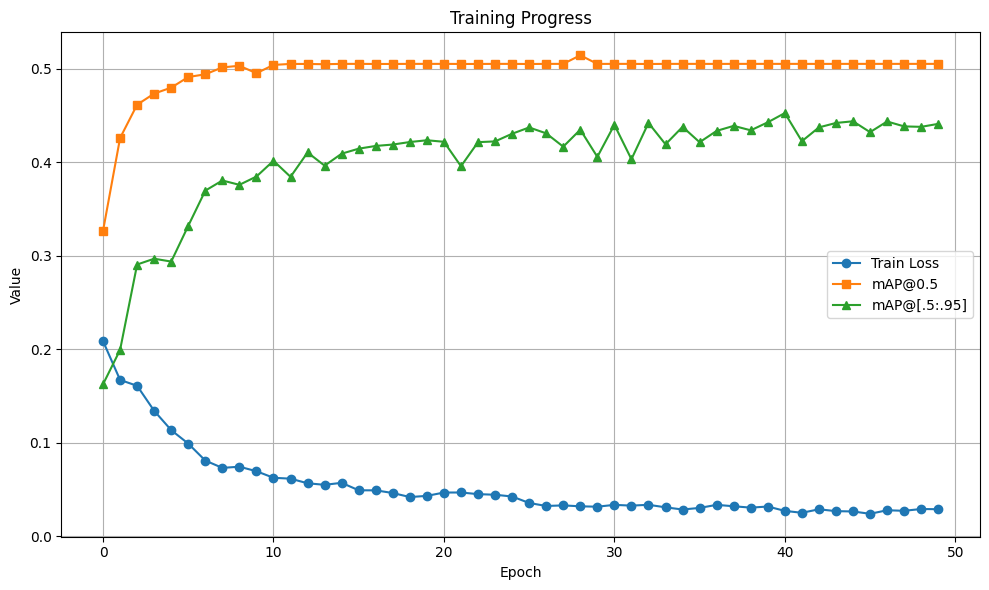

In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

# 訓練紀錄的根資料夾
root_dir = "/content/drive/MyDrive/fasterrcnn/"

# 找最新的 train_log.csv
log_files = sorted(
    glob.glob(os.path.join(root_dir, "**", "train_log.csv"), recursive=True),
    key=os.path.getmtime
)

if not log_files:
    raise ValueError(f"在 {root_dir} 找不到 train_log.csv")

latest_log = log_files[-1]
log_dir = os.path.dirname(latest_log)
print(f"使用訓練紀錄：{latest_log}")

# 讀取訓練紀錄
df = pd.read_csv(latest_log)

# 畫圖
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', marker='o')
plt.plot(df['epoch'], df['mAP_50'], label='mAP@0.5', marker='s')
plt.plot(df['epoch'], df['mAP'], label='mAP@[.5:.95]', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.tight_layout()

# 儲存圖檔
save_path = os.path.join(log_dir, "training_plot.png")
plt.savefig(save_path)
print(f"圖檔已儲存至：{save_path}")

# 顯示圖
plt.show()


抓指定的資料夾


使用訓練紀錄：/content/drive/MyDrive/fasterrcnn/20250719_043750/train_log.csv
圖檔已儲存至：/content/drive/MyDrive/fasterrcnn/20250719_043750/training_plot.png


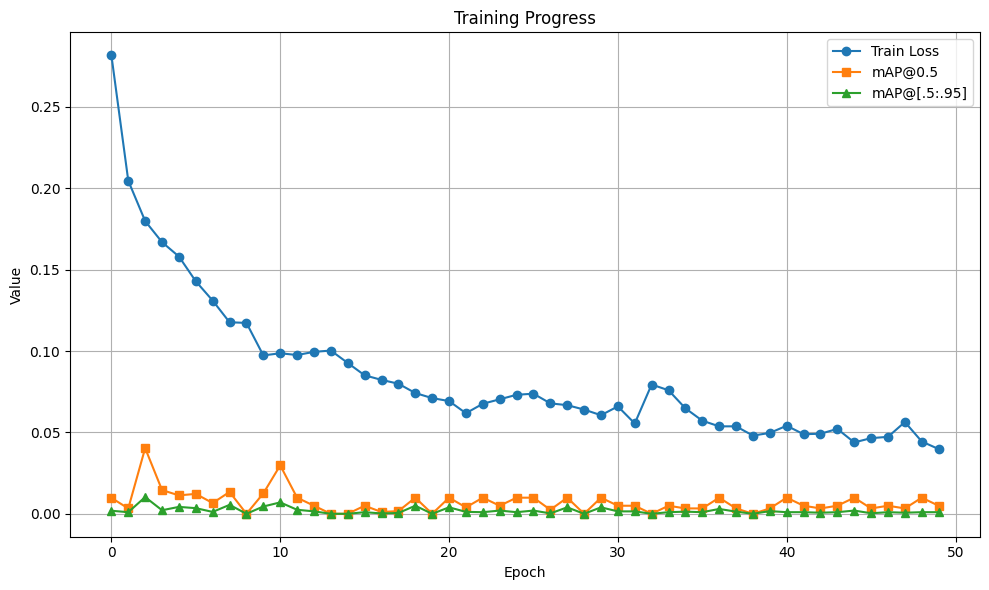

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 訓練紀錄的根資料夾
root_dir = "/content/drive/MyDrive/fasterrcnn/"

# 手動指定要畫圖的子資料夾名稱（請修改這一行）
subfolder = "20250719_043750"  # ← 這裡換成你要的資料夾名稱

# 拼出完整路徑
log_dir = os.path.join(root_dir, subfolder)
csv_path = os.path.join(log_dir, "train_log.csv")

# 檢查檔案是否存在
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"找不到指定的 train_log.csv：{csv_path}")

print(f"使用訓練紀錄：{csv_path}")

# 讀取訓練紀錄
df = pd.read_csv(csv_path)

# 畫圖
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', marker='o')
plt.plot(df['epoch'], df['mAP_50'], label='mAP@0.5', marker='s')
plt.plot(df['epoch'], df['mAP'], label='mAP@[.5:.95]', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.tight_layout()

# 儲存圖檔
save_path = os.path.join(log_dir, "training_plot.png")
plt.savefig(save_path)
print(f"圖檔已儲存至：{save_path}")

# 顯示圖
plt.show()
